# Final Project – Module 1

### Import packages and datasets that will be used throughout investigation

In [2]:
#--- IMPORT NECESSARY PACKAGES ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pandasql import sqldf
import statistics

#--- BASIC GLOBAL DECLARATIONS ---
pysqldf = lambda q: sqldf(q, globals())
%matplotlib inline

In [3]:
#--- IMPORT DATA FROM EXTERNAL CSVs ---

# basic title data from IMDb
path = os.path.join('data','imdb.title.basics.csv')
imdb_title_basics = pd.read_csv(path)

# review data from IMDb
path = os.path.join('data','imdb.title.ratings.csv')
imdb_title_ratings = pd.read_csv(path)

# movie basic details from Rotten Tomatoes
path = os.path.join('data','rt.movie_info.tsv')
rt_movie_info = pd.read_csv(path, delimiter = '\t')

# review data from Rotten Tomatoes
path = os.path.join('data','rt.reviews.tsv')
rt_reviews = pd.read_csv(path, delimiter = '\t', encoding= 'unicode_escape')

# wide ranging data from The Movie Database, largely used for popularity ratings
path = os.path.join('data','tmdb.movies.csv')
tmdb_movies = pd.read_csv(path).drop('Unnamed: 0', axis=1)

# budget data from The Numbers
path = os.path.join('data','tn.movie_budgets.csv')
tn_movie_budgets = pd.read_csv(path)

### Aggregate data from various sources to create one cohesive dataframe containing only relevant data

In [4]:
#--- COMBINE AND CLEAN FINANCIAL DATA ---

finance = tn_movie_budgets[['movie', 'production_budget', 
                            'domestic_gross','worldwide_gross']].copy()

# clean data: remove '$' and ',' then convert to float
production_budget = [float(x.replace('$', '').replace(',','')) for x in finance.production_budget] 
domestic_gross = [float(x.replace('$', '').replace(',','')) for x in finance.domestic_gross]
worldwide_gross = [float(x.replace('$', '').replace(',','')) for x in finance.worldwide_gross]

# input recently cleaned data back into finance dataframe
finance['production_budget'] = production_budget
finance['domestic_gross'] = domestic_gross
finance['worldwide_gross'] = worldwide_gross

# calculate profit as gross revenue minus production budget
finance['profit'] = finance['worldwide_gross'] - finance['production_budget']

In [5]:
#--- CREATE LIST OF ALL POSSIBLE GENRES --- 

# Note: the current formatting shows multiple genres in each 
#       genre cell, separated by commas. The below analysis
#       instead creates a separate column for each genre and
#       represents the data as binary 1 or 0 to indicate whether
#       a given film is classified within that genre

genres_messy = imdb_title_basics['genres'].dropna().unique()
genres_clean = []
for genre in genres_messy:
    for genre_split in genre.split(','):
        genres_clean.append(genre_split)
genres_clean = list(set(genres_clean))


genres = imdb_title_basics.loc[imdb_title_basics['genres'].isna() == False].copy()
for colname in genres_clean:
    genres[colname] = [colname in x for x in genres['genres']]

In [6]:
#--- DROP COLUMNS UNWANTED IN FINAL DATAFRAME ---

# Note that this should be kept in a separate cell since running it
# multiple times results in an error if the column is already dropped

imdb_title_basics.drop(['original_title', 'genres'], 
                       axis=1, inplace=True)

tmdb_movies.drop(['original_title', 'id', 
                  'original_language'], axis=1, inplace=True)

genres.drop(['start_year', 'runtime_minutes', 'genres', 
                'original_title', 'primary_title'], axis=1, inplace=True)

# renaming now makes future SQL join cleaner
finance = finance.rename(columns = {'movie': 'primary_title'})
tmdb_movies = tmdb_movies.rename(columns = {'title': 'primary_title'})


In [7]:
#--- CREATE DATAFRAME THAT AGGREGATES ALL RELEVANT DATA FROM ALL RELEVANT SOURCES ---
q = '''
SELECT * FROM imdb_title_basics
LEFT JOIN finance USING (primary_title) 
LEFT JOIN tmdb_movies USING (primary_title)
LEFT JOIN genres USING (tconst);'''

# Use SQL to connect relevant dataframes
all_data = pysqldf(q)

# convert "None" values/types to NaN for easier manipulation and consistency
all_data.fillna(value=np.nan, inplace=True) 

# unused data for now. add later for additional depth if time permits
tmdb_genre_id_dict = {
'28': 'Action',
'12': 'Adventure',
'16': 'Animation',
'35': 'Comedy',
'80': 'Crime',
'99': 'Documentary',
'18': 'Drama',
'10751': 'Family',
'14': 'Fantasy',
'36': 'History',
'27': 'Horror',
'10402': 'Music',
'9648': 'Mystery',
'10749': 'Romance',
'878': 'Science Fiction',
'10770': 'TV Movie',
'53': 'Thriller',
'10752': 'War',
'37': 'Western'}

## Begin Analysis of Data

In [15]:
# --- AGGREGATE DATA *FOR EACH GENRE* INTO ONE DATAFRAME ---
GENRES = list(genres.columns[1:])
df_genres = pd.DataFrame(GENRES)
df_genres.columns = ['genre']
df_genres.sort_values(by='genre', inplace=True)
df_genres.reset_index(inplace=True, drop=True)

In [16]:
# --- START WITH FINANCIALS ---
profit_median = []
profit_mean = []
for g in GENRES:
    profit = all_data.loc[(all_data['profit'].isna() == False) &
                          (all_data[g] == True), 'profit']
    profit_median.append(profit.median())
    profit_mean.append(profit.mean())
 
    
df_genres['profit_median'] = profit_median
df_genres['profit_mean'] = profit_mean


# --- PROFITABILITY RANK ---
df_genres.sort_values(by='profit_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['profit_rank'] = list(rank)
df_genres.reset_index(drop=True, inplace=True)


# plt.figure(figsize=(15,6))
# plt.barh(df_genres['genre'], df_genres['profit_median'])
# plt.title('Median Profit by Genre ($)')
# plt.show()

In [17]:
# --- POPULARITY ---

popularity_median = []
popularity_mean = []
for g in GENRES:
    popularity = all_data.loc[(all_data['popularity'].isna() == False) &
                          (all_data[g] == True), 'popularity']
    popularity_median.append(popularity.median())
    popularity_mean.append(popularity.mean())
    
df_genres['popularity_median'] = popularity_median
df_genres['popularity_mean'] = popularity_mean


# --- POPULARITY RANK ---
df_genres.sort_values(by='popularity_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['popularity_rank'] = list(rank)
df_genres.reset_index(drop=True, inplace=True)

# plt.figure(figsize=(15,6))
# plt.barh(df_genres['genre'], df_genres['popularity_median'])
# plt.title('Median Popularity by Genre')
# plt.show()

In [18]:
# --- VOTE AVG ---
MIN_VOTE_CT = 20

vote_median = []
vote_mean = []
for g in GENRES:
    vote = all_data.loc[(all_data['vote_average'].isna() == False) &
                        (all_data['vote_count'] >= MIN_VOTE_CT) &
                          (all_data[g] == True), 'vote_average']
    vote_median.append(vote.median())
    vote_mean.append(vote.mean())
    
df_genres['vote_median'] = vote_median
df_genres['vote_mean'] = vote_mean

# --- VOTE RANK ---
df_genres.sort_values(by='vote_median', ascending=False, inplace=True)
rank = df_genres.reset_index(drop=True).index
df_genres['vote_rank'] = list(rank)
df_genres.reset_index(drop=True, inplace=True)


# plt.figure(figsize=(15,6))
# plt.barh(df_genres['genre'], df_genres['vote_median'])
# plt.title('Median Vote by Genre')
# plt.show()

In [19]:
# --- MOVIE CT ---
movie_ct = []
for g in GENRES:
    ct = all_data.loc[(all_data[g] == True), g]
    movie_ct.append(ct.sum())
    
df_genres['movie_ct'] = movie_ct
df_genres.drop(['vote_mean', 'vote_median', 'vote_rank'], axis=1, inplace=True)
df_genres.dropna(inplace=True)

In [30]:
MIN_MOVIE_CT = 2000
MED_MOVIE_CT = df_genres['movie_ct'].median()
print(MED_MOVIE_CT)
df_genres = df_genres.loc[df_genres['movie_ct'] > MIN_MOVIE_CT].sort_values(by='movie_ct').copy()

3682.0


In [31]:
min_profitrank = 20
min_poprank = 10
num_to_include_in_leaders = 10
leading_genres = df_genres.loc[(df_genres['profit_rank'] <= min_profitrank)].copy()
#leading_genres = df_genres.loc[(df_genres['popularity_mean'] <= min_poprank)].copy()
#leading_genres = df_genres.copy()
leading_genres.sort_values(by='popularity_mean', ascending=False, inplace=True)
leading_genres = leading_genres.iloc[:num_to_include_in_leaders].copy()


others = all_data.copy()
droppable = ['primary_title', 'start_year', 'runtime_minutes', 'genre_ids', 'production_budget',
             'release_date', 'vote_average', 'vote_count', 'domestic_gross', 'worldwide_gross']
others = others.drop(droppable, axis=1).dropna()


trailing_genres = df_genres.copy()
for g in list(df_genres['genre']):
    if g in list(leading_genres['genre']):
        x = df_genres.loc[df_genres.genre == g].index
        trailing_genres.drop(index=x, inplace=True)

profit_agg = []
pop_agg = []
ct = 0
for g in list(trailing_genres['genre']):
    pop = all_data.loc[(all_data['popularity'].isna() == False) & (all_data[g] == True), 'popularity']
    pop_agg.append(list(pop))

    profit = all_data.loc[(all_data['profit'].isna() == False) & (all_data[g] == True), 'profit']
    profit_agg.append(list(profit))

    ct += len(all_data.loc[(all_data['tconst'].isna() == False) & (all_data[g] == True), 'tconst'])
    
profit_flat = [val for sublist in profit_agg for val in sublist]
profit_median = statistics.median(profit_flat)
profit_mean = statistics.mean(profit_flat)
    
    
pop_flat = [val for sublist in pop_agg for val in sublist]
pop_median = statistics.median(pop_flat)
pop_mean = statistics.mean(pop_flat)

rank = leading_genres.profit_rank.max() + 1

leading_genres = leading_genres.append({'genre': 'All Others',
                       'profit_median': profit_median,
                       'profit_mean': profit_mean,
                       'profit_rank': rank,
                       'popularity_median': pop_median,
                       'popularity_mean':pop_mean,
                       'popularity_rank':rank,
                       'movie_ct': ct}, ignore_index=True)
leading_genres

,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,movie_ct
0,Documentary,6898293.0,4.563700e+07,15,3.7175,6.810780,4,6376.0
1,Adventure,64950630.5,2.922556e+08,1,2.2130,4.349066,10,52267.0
2,Crime,8462398.0,1.288383e+08,13,1.9355,4.265355,15,52537.0
3,Action,4299670.0,4.964393e+07,18,1.9660,4.108007,13,10806.0
4,War,85294313.5,1.940365e+08,0,2.0720,4.095901,11,3571.0
5,Horror,9876855.0,4.926510e+07,12,3.9030,3.897000,2,5755.0
6,Animation,25023759.0,1.097484e+08,6,1.5395,3.822943,18,8990.0
7,Biography,11507410.0,5.656655e+07,11,1.8470,3.655558,16,4940.0
8,Family,17047364.5,1.500886e+08,7,1.9530,3.630725,14,2906.0
9,Talk-Show,2434356.0,3.733343e+07,20,0.6970,3.243200,24,2308.0


In [32]:
trailing_genres

,genre,profit_median,profit_mean,profit_rank,popularity_median,popularity_mean,popularity_rank,movie_ct
15,Reality-TV,-2541971.0,1.748987e+07,22,4.4065,7.857636,1,3682.0
24,Game-Show,4856688.0,3.903443e+07,16,2.4070,2.407000,7,6462.0
23,Sci-Fi,-1000000.0,-1.000000e+06,21,1.3450,1.345000,21,7132.0
19,Comedy,28031715.0,2.208677e+07,5,0.6600,1.733840,26,9765.0
7,News,7685268.0,5.307152e+07,14,0.6965,0.696500,25,11427.0


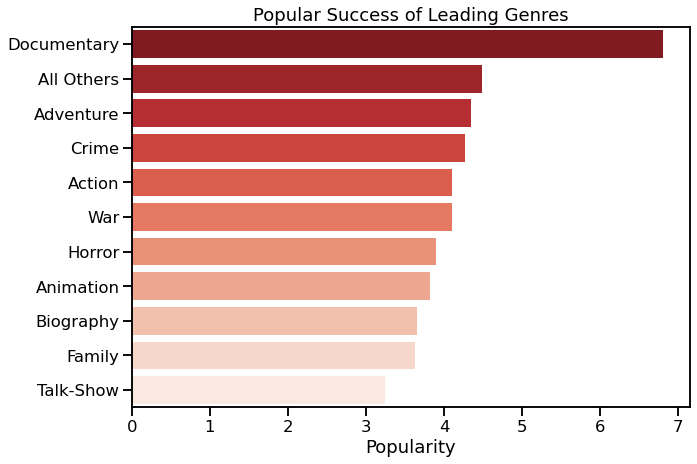

In [33]:
leading_genres.sort_values(by='popularity_mean', ascending=False, inplace=True)

sns.set_context('talk') 
#sns.set_palette("Reds_r") #twilight_shifted_r also an option
f, ax = plt.subplots(1, 1, figsize=(10, 7), sharex=True)

x = leading_genres['genre']
y = leading_genres['popularity_mean']

sns.set_palette("Reds_r")
sns.barplot(data = leading_genres, 
            y = 'genre', 
            x = 'popularity_mean', 
            ax=ax, 
            palette='Reds_r', orient='h')
plt.ylabel('')
plt.xlabel('Popularity')#('Median Movie Profit (Million $)')
sns.set_palette("Reds_r")
ax.set_title('Popular Success of Leading Genres')
#plt.savefig('images/Financial Success of Leading Genres.png')
sns.set_palette("Reds_r")

In [35]:
all_data

,tconst,primary_title,start_year,runtime_minutes,production_budget,domestic_gross,worldwide_gross,profit,genre_ids,popularity,...,Documentary,Western,Romance,Reality-TV,Short,Adventure,Crime,Family,Animation,Mystery
0,tt0063540,Sunghursh,2013,175.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,tt0066787,One Day Before the Rainy Season,2019,114.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,tt0069049,The Other Side of the Wind,2018,122.0,NaN,NaN,NaN,NaN,"[35, 18]",9.8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,tt0069204,Sabse Bada Sukh,2018,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,tt0100275,The Wandering Soap Opera,2017,80.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150825,tt9916538,Kuambil Lagi Hatiku,2019,123.0,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150826,tt9916622,Rodolpho Teóphilo - O Legado de um Pioneiro,2015,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150827,tt9916706,Dankyavar Danka,2013,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
150828,tt9916730,6 Gunn,2017,116.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,profit,popularity
20,-44926294.0,4.705
40,965996.0,6.576
48,-15686698.0,8.919
54,96861183.0,10.743
58,34108587.0,19.373
...,...,...
150619,-79448583.0,10.158
150620,-79448583.0,0.600
150708,410511.0,8.964
150761,70720921.0,14.010


,profit,popularity
20,-44926294.0,4.705
40,965996.0,6.576
48,-15686698.0,8.919
54,96861183.0,10.743
58,34108587.0,19.373
...,...,...
150619,-79448583.0,10.158
150620,-79448583.0,0.600
150708,410511.0,8.964
150761,70720921.0,14.010


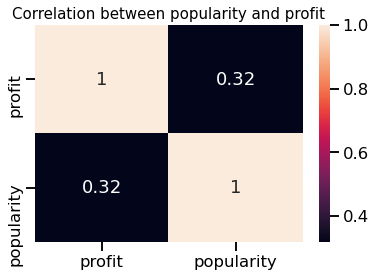

In [73]:
tester = all_data[['profit', 'popularity']].dropna()


#corrMatrix = df_genres[['profit_median', 'popularity_median']].dropna().corr()
corrMatrix = stdrem[['profit', 'popularity']].dropna().corr()
sns.heatmap(corrMatrix, annot=True)
plt.title("Correlation between popularity and profit", fontsize=15)
tester

In [72]:
profit_std = tester['profit'].std() 
profit_med = tester['profit'].median()
profit_lo = profit_med - 3 * profit_std
profit_hi = profit_med + 3 * profit_std

ind1 = tester.loc[(tester['profit'] > profit_hi) | 
            (tester['profit'] < profit_lo)]


pop_std = tester['popularity'].std() 
pop_med = tester['popularity'].median()
pop_lo = pop_med - 4 * pop_std
pop_hi = pop_med + 4 * pop_std

ind2 = tester.loc[(tester['popularity'] > pop_hi) | 
            (tester['popularity'] < pop_lo)]

stdrem = tester.drop(ind1.index.append(ind2.index))

Text(0.5, 1.0, 'Effect of Popularity on Financial Success')

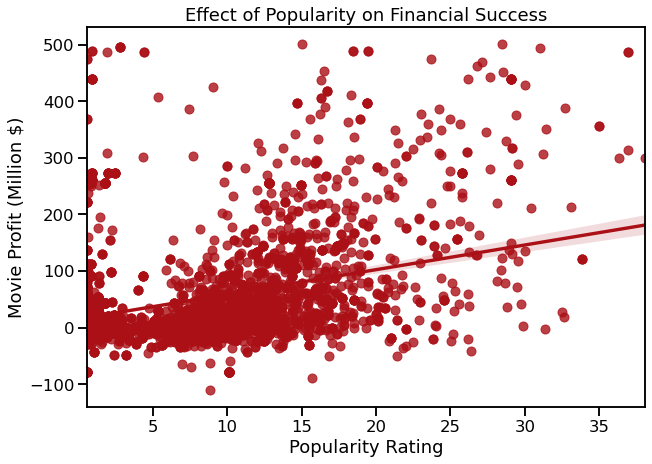

In [74]:



sns.set_context('talk') 
sns.set_palette("Reds_r") #twilight_shifted_r also an option
f, ax = plt.subplots(1, 1, figsize=(10, 7), sharex=True)

x = stdrem['popularity']
y = stdrem['profit']/10**6

sns.regplot(x=x, y=y, ax=ax)
plt.xlabel('Popularity Rating')
plt.ylabel('Movie Profit (Million $)')
ax.set_title('Effect of Popularity on Financial Success')
#plt.savefig('images/Effect of Popularity on Financial Success.png')

# Notes From Call with Joel

- Consider frequency that each genre is produced. 

- Is there anything in this data that says starting with high popularity could lead to later profitability?

- If popularity is so vital, need to define more clearly how that is narrowed. Then, take a look at the most popular movies; profile these aspects to see "what works" and what doesn't

- Consider budgets too since that is especially relevant to companies breaking into a market

- Anything from Runtime?

- Look into top actors -- this could be something they would "need" to have in new films

- Try to create distinction between that the popular and unpopular factors are

- Tell them "what they should care about, and what they shouldn't care about". Second point is less necessary, but can be helpful

- Popular includes number of films produced in that genre, not just ratings

- Also look at distributions of this data, not just median. The company will also care about the confidence interval for these calculations.